# Quality Engineering

M.Riki

### 3ヶ月目 問2
微粒子分散剤あるいは顔料インクの粘度調整剤として活用されるペースト用ビヒクルは、溶剤でバインダー樹脂を溶解して製造される。
ビヒクルの重要な品質特性は粘度であるが、現行の製造条件では、ばらつきが大きく、廃棄や再生などによる損失は、ビヒクル1kgあたり、約65円である。
粘度安定性を改善するため、制御因子としてA~Gをとりあげ、直交表$L_{18}$の1~7列にわりつけた。
信号因子Mは、粘度を変化させるための因子として樹脂濃度を

$$M_1=8\%, M_2=10\%, M_3=15\%$$

とし、ノイズは、

$$N_1=粘度が低くなる抜き終わり, N_2=粘度が高くなる抜き始め$$

として、粘度yを測定した。
粘度yは、設定した信号Mの範囲では、Mに比例することが知られているが、M=0でy=0ではないので、$M_1$を基準点にした基準点比例のSN比で評価するのが妥当と考えられる。

---

#### Initialization

In [27]:
%pylab inline
import pandas as pd
pd.set_option('display.precision', 5)
#import seaborn

Populating the interactive namespace from numpy and matplotlib


In [28]:
from IPython.core.display import HTML
HTML(open("styles/custom.css", "r").read())

#### Function Definition

In [29]:
def plotEffect(df,margin=0.5):
    fig,axes = plt.subplots(1,df.index.size,sharey=True)
    fig.set_size_inches(df.index.size*1.5,2)
    for i in arange(df.index.size):
        ax = axes[i]
        ax.plot(df.columns,df.ix[i,:],'o-')
        ax.set_xlim(0.7,3.3)
        ax.set_ylim(df.min().min()-margin,df.max().max()+margin)
        ax.set_title(df.index[i])
        ax.set_xticks([1,2,3])
    print "\n効果図"
    plt.tight_layout()
    plt.show()

In [30]:
# 動特性の２乗和分解
def dynamicProp(M,A, calcSN=False, calcS=False, calcB=False, calcStandardSN=False):
    # Degree of Freedom
    Ft = len(A.index)*len(A.columns)
    Fb = 1
    Fnb = len(A.index) - 1
    Fe = Ft - Fb - Fnb
    Fn = Fnb + Fe
    # Squared Sum
    St = (A*A).sum().sum() #eq(4.7)
    L = np.asarray(A).dot(M) # A[3,3]とM[3,1]の行列積[3,1]
    r = (M*M).sum()
    Sb = (L.sum())**2/len(A.index)/r #eq(4.8)
    Snb = (L*L).sum()/r - Sb #eq(4.9)
    Se = St - Sb - Snb
    Sn = Snb + Se
    # Variance
    Vb = Sb/Fb
    Vnb = Snb/Fnb
    Ve = Se/Fe
    Vn = Sn/Fn
    
    # calcSNratio[db]
    if calcSN==True:
        eta = (1./len(A.index)/r*(Sb-Ve))/Vn #eq(4.15)
        return 10*np.log10(eta)
    
    # calc Standard SN ratio[db]
    if calcStandardSN==True:
        eta = (Sb-Ve)/Vn #eq(7.8)
        return 10*np.log10(eta)
    
    # calcS[db]
    if calcS==True:
        S = (1./len(A.index)/r*(Sb-Ve))
        return 10*np.log10(S)
    
    # calcB
    if calcB==True:
        beta = L.mean()/r
        return beta
    
    # PrintTable
    data = {'F': [Fb,Fnb,Fe,Fn,Ft], 'S':[Sb,Snb,Se,Sn,St], 'V':[Vb,Vnb,Ve,Vn,nan]}
    df = pd.DataFrame(data=data, index=["b","N*b","e","(N)","T"])
    print df

---

#### 1) No.1のデータは以下のようである。$M_1$を基準点にした基準点比例のSN比を求めよ。

N1のデータ↓


A
       M1     M2     M3
N1  34.16  55.30  92.37
N2  33.18  58.13  92.47


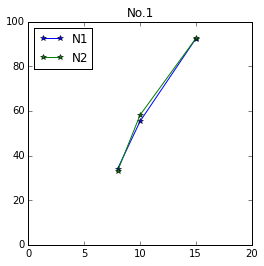

In [31]:
MnoFix = np.asarray([8, 10, 15])
AnoFix = pd.DataFrame([[34.16,55.30,92.37],
                      [33.18,58.13,92.47]],
                     index=["N1","N2"],
                     columns=["M1","M2","M3"])
print "\nA\n",AnoFix
fig = figure(figsize=(4,4))
ax = plt.subplot(111)
ax.plot(MnoFix,AnoFix.T,'*-')
ax.set_title("No.1")
ax.legend(["N1","N2"],loc="best")
ax.set_xlim(0,20)
ax.set_ylim(0,100)
plt.show()

$M_1$を基準点にして補正したデータは以下のようになる。

In [32]:
M = MnoFix-MnoFix[0]
A = AnoFix-AnoFix["M1"].mean()
print "M\n", M
print "\nA\n",A

M
[0 2 7]

A
      M1     M2    M3
N1  0.49  21.63  58.7
N2 -0.49  24.46  58.8


No.1の2乗和分解表する

In [33]:
print "No.1の2乗和分解表"
dynamicProp(M,A)  

No.1の2乗和分解表
     F          S          V
b    1  7892.8255  7892.8255
N*b  1     0.3816     0.3816
e    4    76.5516    19.1379
(N)  5    76.9332    15.3866
T    6  7969.7587        NaN


In [34]:
print "No.1のSN比は、%.2f(db)"%dynamicProp(M,A, calcSN=True)

No.1のSN比は、6.84(db)


    No.1のSN比は、6.84(db)

---

#### 2) SN比の補助表（水準別合計）は次のようである。次の最適条件のSN比を推定し、現行条件のSN比(すべて第1水準)に対する利得を求めよ。

In [35]:
SNsum = pd.DataFrame([[74.69,44.76,nan],
                      [41.94,40.51,37.00],
                      [39.59,40.83,39.03],
                      [37.87,38.63,42.95],
                      [37.80,36.76,44.89],
                      [39.56,39.02,40.87],
                      [35.62,39.87,43.96]],
                     index=list("ABCDEFG"),
                     columns=["1","2","3"])
print "\nSN比の水準別合計\n",SNsum


SN比の水準別合計
       1      2      3
A  74.69  44.76    NaN
B  41.94  40.51  37.00
C  39.59  40.83  39.03
D  37.87  38.63  42.95
E  37.80  36.76  44.89
F  39.56  39.02  40.87
G  35.62  39.87  43.96



SN比の水準別平均
        1       2       3
A  8.2989  4.9733     NaN
B  6.9900  6.7517  6.1667
C  6.5983  6.8050  6.5050
D  6.3117  6.4383  7.1583
E  6.3000  6.1267  7.4817
F  6.5933  6.5033  6.8117
G  5.9367  6.6450  7.3267

効果図


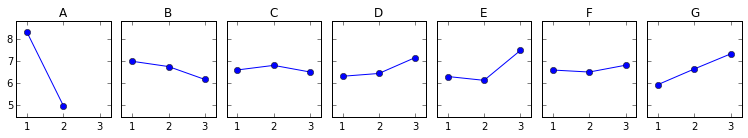

In [36]:
SNave = pd.DataFrame.copy(SNsum)
SNave.ix[:1,:] = SNsum.ix[:1,:]/9
SNave.ix[1:,:] = SNsum.ix[1:,:]/6
print "\nSN比の水準別平均\n",SNave
plotEffect(SNave)

最適条件はA1B1C2D3E3F3G3である

In [37]:
ave = SNsum.sum(1)[0]/18
eta_opt = SNave.ix["A","1"]+SNave.ix["B","1"]+SNave.ix["C","2"]\
+SNave.ix["D","3"]+SNave.ix["E","3"]+SNave.ix["F","3"]+SNave.ix["G","3"]-6*ave
eta_ini = SNave.sum(0)[0]-6*ave 
eta_diff = eta_opt-eta_ini
print "最適条件のSN比は、%.1f(db)"%eta_opt
print "現行条件のSN比は、%.1f(db)"%eta_ini
print "\n利得は、%.1f(db)。真数に直すと、%.2f。"%(eta_diff, 10**(eta_diff/10))

最適条件のSN比は、11.1(db)
現行条件のSN比は、7.2(db)

利得は、3.8(db)。真数に直すと、2.42。


    最適条件のSN比は、11.1(db)
    現行条件のSN比は、7.2(db)
    利得は、3.8(db)。真数に直すと、2.42。

---

#### 3)最適条件について品質水準を求めよ。

現行の品質水準は65(円/kg)であり、(2)より最適条件では2.42の利得があるから、

In [38]:
print "最適条件の品質水準は、%d(円/kg)"%(65/2.42)

最適条件の品質水準は、26(円/kg)


    最適条件の品質水準は、26(円/kg)

---

#### 4)各因子の現行水準に対する水準別のコスト差は次表のとおりである。コストを含めた場合、SN比の最適条件と現行条件の優劣を比較せよ。コストを考慮したとき、さらに有利な条件があるか検討せよ。

In [39]:
cost = pd.DataFrame([[0.0,27.8,nan],
                      [0.0,6.5,-7.2],
                      [0.0,7.5,-4.5],
                      [0.0,3.8,7.5],
                      [0.0,3.0,6.0],
                      [0.0,2.4,4.8],
                      [0.0,0.6,1.3]],
                     index=list("ABCDEFG"),
                     columns=["1","2","3"])
print "\n現行水準に対するコスト差(円/kg)\n",cost


現行水準に対するコスト差(円/kg)
   1     2    3
A  0  27.8  NaN
B  0   6.5 -7.2
C  0   7.5 -4.5
D  0   3.8  7.5
E  0   3.0  6.0
F  0   2.4  4.8
G  0   0.6  1.3


最適条件A1B1C2D3E3F3G3におけるコストアップは

In [40]:
cost_opt = cost.ix["A","1"]+cost.ix["B","1"]+cost.ix["C","2"]\
+cost.ix["D","3"]+cost.ix["E","3"]+cost.ix["F","3"]+cost.ix["G","3"]
print "%d(円/kg)"%(cost_opt)

27(円/kg)


最適条件の品質にコストアップを含めても

In [41]:
print "%d(円/kg)"%(cost_opt+65/2.42)

53(円/kg)


    となり、現行の65(円/kg)よりも優れている


**さらに有利な条件があるかの検討**

(2)で導出した、SN比の水準別平均表をすべてコスト変化量に換算すると

In [42]:
SNcost = pd.DataFrame.copy(SNave)
SNcost.ix[:,0] = 0
SNcost.ix[:,1] = 65/(10**((SNave.ix[:,1]-SNave.ix[:,0])/10))-65
SNcost.ix[:,2] = 65/(10**((SNave.ix[:,2]-SNave.ix[:,0])/10))-65
print "\nSN比の、現行水準に対するコスト差換算(円/kg)\n",SNcost


SN比の、現行水準に対するコスト差換算(円/kg)
   1        2        3
A  0  74.7877      NaN
B  0   3.6668  13.5682
C  0  -3.0207   1.4120
D  0  -1.8684 -11.5132
E  0   2.6467 -15.4839
F  0   1.3611  -3.1870
G  0  -9.7821 -17.8031



品質水準とコストを合わせた各水準への変更効果(円/kg)
   1         2        3
A  0  102.5877      NaN
B  0   10.1668   6.3682
C  0    4.4793  -3.0880
D  0    1.9316  -4.0132
E  0    5.6467  -9.4839
F  0    3.7611   1.6130
G  0   -9.1821 -16.5031

効果図


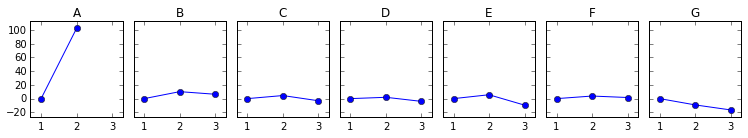

In [43]:
quality = cost + SNcost
print "\n品質水準とコストを合わせた各水準への変更効果(円/kg)\n", quality
plotEffect(quality,margin=10)

したがって、コストまで考慮した最適水準はA1B1C3D3E3F1G3で、
このときの品質特性は、

In [44]:
quality_opt = 65 + quality.ix["A","1"]+quality.ix["B","1"]+quality.ix["C","3"]\
+quality.ix["D","3"]+quality.ix["E","3"]+quality.ix["F","1"]+quality.ix["G","3"]
print "%d(円/kg)"%(quality_opt)

31(円/kg)


    となり、SN比のみを考慮した最適条件の場合=53(円/kg)よりもさらに有利な条件である。

---

#### Library Version

In [45]:
%load_ext version_information
%version_information numpy, matplotlib, pandas, version_information

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.9 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.56)]
IPython 4.0.0
OS Darwin 14.4.0 x86_64 i386 64bit
numpy 1.10.0.dev+a02f5c8
matplotlib 1.4.2
pandas 0.16.0
version_information 1.0.3
Wed Aug 12 23:47:29 2015 JST